In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from enum import Enum
from scipy.stats import norm
from scipy import integrate

DF = pd.read_csv('Discount_Factors.csv')

DF.rename(columns = {'Unnamed: 0': ' '}, inplace = True)

DF.index = DF.iloc[:, 0]

DF.drop(columns = ' ', inplace = True)


sabr_calib = pd.read_csv('df_calibrated_sabr.csv').drop(columns = 'Unnamed: 0')

SABR_vol = sabr_calib.iloc[:, :13]

SABR_params = sabr_calib.iloc[:, [0, 1, -3, -2, -1]]

#### Interpolate SABR parameters for CMS 10x5 

In [2]:
start_p = np.linspace(0.5, 10, 20)
tenor_p = 10.0

cms1_p = pd.DataFrame({'start': start_p, 'tenor': tenor_p})
cms1_p.loc[[1, 9, 19], ['alpha', 'rho', 'nu']] = SABR_params.loc[[4, 9, 14], ['alpha_sabr', 'rho_sabr', 'nu_sabr']].values
cms1_p = cms1_p.interpolate(method='spline', order=2)
diff0 = cms1_p.loc[1, ['alpha', 'rho', 'nu']] - cms1_p.loc[2, ['alpha', 'rho', 'nu']]
cms1_p.loc[0, ['alpha', 'rho', 'nu']] = cms1_p.loc[1, ['alpha', 'rho', 'nu']] + diff0

cms1_params = pd.read_csv('swap_cms10x5.csv').drop(columns = 'Unnamed: 0')
cms1_params[['alpha', 'rho', 'nu']] = np.nan
cms1_params.loc[0:9, ['alpha', 'rho', 'nu']] = cms1_p.loc[0:9, ['alpha', 'rho', 'nu']].values

cms1_params['Discount'] = DF.loc[0.5:5, 'OIS_discount_list'].values
#interpolate SABR parameters alpha, rho, nu

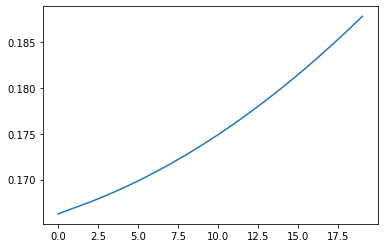

In [3]:
plt.plot(cms1_p.alpha);

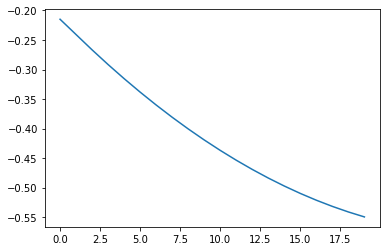

In [4]:
plt.plot(cms1_p.rho);

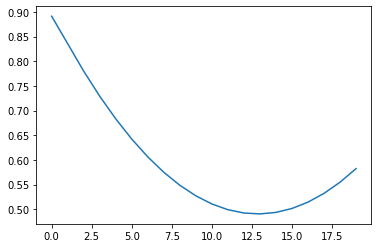

In [5]:
plt.plot(cms1_p.nu)

In [6]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

## Q1
For static replication of any constant maturity swap (CMS) payoff $g(F)$, we use the following formula:

  \begin{equation*}
    \begin{split}
      V_0 &= D(0,T) g(F) + h'(F)[V^{pay}(F)-V^{rec}(F)] \\
      &\;\;\;\;\;\;\;\;\;\;+ \int_0^F h''(K) V^{rec}(K) dK +
      \int_F^\infty h''(K) V^{pay}(K) dK
    \end{split}
  \end{equation*}

where

  \begin{equation*}
    \begin{split}
      h(K) &= \frac{g(K)}{\mbox{IRR}(K)} \\
      h'(K) &= \frac{\mbox{IRR}(K)g'(K) - g(K)\mbox{IRR}'(K)}{\mbox{IRR}(K)^2} \\
      h''(K) &= \frac{\mbox{IRR}(K)g''(K)-\mbox{IRR}''(K)g(K) -2\cdot\mbox{IRR}'(K)g'(K)}{\mbox{IRR}(K)^2} \\
      &\;\;\;\;\;\;\;\;\;\;+
      \frac{2\cdot\mbox{IRR}'(K)^2g(K)}{\mbox{IRR}(K)^3}.
    \end{split}
  \end{equation*}
  
For CMS rate payoff, the payoff function can be defined simply as $g(F)=F$, and the static replication formula simplifies into:

  \begin{equation*}
    \begin{split}
      D(0,T) F + \int_0^F h''(K) V^{rec}(K) dK + \int_F^\infty h''(K) V^{pay}(K) dK
    \end{split}
  \end{equation*}
  
The partial derivatives on the IRR function $\mbox{IRR}(S)$ given by:
\begin{equation*}
\begin{split}
\mbox{IRR}(K)&=\sum_{i=1}^{N\times m}\frac{1}{(1+\frac{K}{m})^i}=\frac{1}{K}\left[1-\frac{1}{\left(1+\frac{K}{m}\right)^{N\times m}}\right]\\
\mbox{IRR}'(K)&=-\frac{1}{K}\mbox{IRR}(K)
+\frac{1}{m\times K}\frac{N\times m}{\left(1+\frac{K}{m}\right)^{N\times m+1}} \\
\mbox{IRR}''(K)&=-\frac{2}{K}\mbox{IRR}'(K)
-\frac{1}{m^2\times K}\frac{N\times m\cdot (N\times m+1)}{\left(1+\frac{K}{m}\right)^{N\times m+2}} \\
\end{split}
\end{equation*}
Implement the IRR-settled payer and receiver swaption formulae:

  \begin{equation*}
    \begin{split}
      V^{pay}_{n,N}(0) &= D(0,T_n) \cdot \mbox{IRR}(S_{n,N}(0)) \cdot \mbox{Black76Call}(S_{n,N}(0),K,\sigma_{n,N},T) \\
      V^{rec}_{n,N}(0) &= D(0,T_n) \cdot \mbox{IRR}(S_{n,N}(0)) \cdot \mbox{Black76Put}(S_{n,N}(0),K,\sigma_{n,N},T) \\
    \end{split}
  \end{equation*}

where $S_{n,N}(0)=F$ is today's forward swap rate calculated based on the curves we bootstrapped, and $\sigma_{n,N}$ is the SABR implied volatility calibrated to swaption market data.

### CMS 10x5 

#### SABR Imp Vol 

In [7]:
#ATM Imp Vol
def get_sabr_vol1(df, beta):
    impvol = []
    for i in range(len(df)):
        F = df.loc[i, 'swap_rates']
        alpha = df.loc[i, 'alpha']
        rho = df.loc[i, 'rho']
        nu = df.loc[i, 'nu']
        T = df.loc[i, 'start'] #pay at T
        impvol.append(SABR(F, F, T, alpha, beta, rho, nu))
    return impvol

beta = 0.9
cms1_params['sabr_vol'] = get_sabr_vol1(cms1_params, beta)

#### PV 

In [9]:
class PayoffType(str, Enum):
    Rec = 'Rec'
    Pay = 'Pay'
def Black76Vanilla(F, K, sigma, T, df, payofftype):
    d1 = (np.log(F/K) + (sigma**2/2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if payofftype == PayoffType.Pay:
        return (F*norm.cdf(d1) - K*norm.cdf(d2))
    elif payofftype == PayoffType.Rec:
        return (K*norm.cdf(-d2) - F*norm.cdf(-d1))

def IRR_0(K, m, N):
    # implementation of IRR(K) function
    value = 1/K * ( 1.0 - 1/(1 + K/m)**(N*m) )
    return value

def IRR_1(K, m, N):
    # implementation of IRR'(K) function (1st derivative)
    firstDerivative = -1/K*IRR_0(K, m, N) + 1/(K*m)*N*m/(1+K/m)**(N*m+1)
    return firstDerivative

def IRR_2(K, m, N):
    # implementation of IRR''(K) function (2nd derivative)
    secondDerivative = -2/K*IRR_1(K, m, N) - 1/(K*m*m)*(N*m)*(N*m+1)/(1+K/m)**(N*m+2)
    return secondDerivative

def g_0(K):
    return K

def g_1(K):
    return 1.0

def g_2(K):
    return 0.0

def h_0(K, m, N):
    # implementation of h(K)
    value = g_0(K) / IRR_0(K, m, N)
    return value

def h_1(K, m, N):
    # implementation of h'(K) (1st derivative)
    firstDerivative = (IRR_0(K, m, N)*g_1(K) - g_0(K)*IRR_1(K, m, N)) / IRR_0(K, m, N)**2
    return firstDerivative

def h_2(K, m, N):
    # implementation of h''(K) (2nd derivative)
    secondDerivative = ((IRR_0(K, m, N)*g_2(K) - IRR_2(K, m, N)*g_0(K) - 2.0*IRR_1(K, m, N)*g_1(K))/IRR_0(K, m, N)**2 
                        + 2.0*IRR_1(K, m, N)**2*g_0(K)/IRR_0(K, m, N)**3)
    return secondDerivative

def integral_rec(F, k, m, N, sigma, T, DiscountFactor):
    return h_2(k, m, N) * IRR_0(k, m, N) * Black76Vanilla(F, k, sigma, T, DiscountFactor, PayoffType.Rec)

def integral_pay(F, k, m, N, sigma, T, DiscountFactor):
    return h_2(k, m, N) * IRR_0(k, m, N) * Black76Vanilla(F, k, sigma, T, DiscountFactor, PayoffType.Pay)

def CMSRate1(df, m, N):
    cms_rate = []
    for i in range(len(df)):
        F = df.loc[i, 'swap_rates']
        sigma = df.loc[i, 'sabr_vol']
        DF = df.loc[i, 'Discount']
        T = df.loc[i, 'start']
        integral1 = integrate.quad(lambda k: integral_rec(F, k, m, N, sigma, T, DF), 0, F)
        integral2 = integrate.quad(lambda k: integral_pay(F, k, m, N, sigma, T, DF), F, np.inf)
        cms_rate.append(g_0(F)+np.sum(integral1+integral2))
    return cms_rate

#T = 10
m = 2
N = 10.0
cms1_params['CMS_rate'] = CMSRate1(cms1_params, m, N)

def CMS_PV1(df):
    pv = 0
    for i in range(len(df)):
        pv += 0.5 * df.loc[i, 'Discount'] * df.loc[i, 'CMS_rate']
    return pv

CMS10x5_PV = CMS_PV1(cms1_params)

CMS10x5_PV

### CMS 2yx10 

#### Interpolate SABR parameters for CMS 2x10

In [16]:
cms2_params = pd.read_csv('swap_cms2x10.csv').drop(columns = 'start.1')
cms2_params[['alpha', 'rho', 'nu']] = np.nan
cms2_params.loc[[3, 19, 39], ['alpha', 'rho', 'nu']] = SABR_params.loc[[4, 9, 14], ['alpha_sabr', 'rho_sabr', 'nu_sabr']].values

#interpolate SABR parameters alpha, rho, nu
cms2_params = cms2_params.interpolate(method='spline', order=2)

diff = cms2_params.loc[3, ['alpha', 'rho', 'nu']] - cms2_params.loc[4, ['alpha', 'rho', 'nu']]
for i in range(0, 3):
    cms2_params.loc[i, ['alpha', 'rho', 'nu']] = cms2_params.loc[3, ['alpha', 'rho', 'nu']] + diff * (3-i)

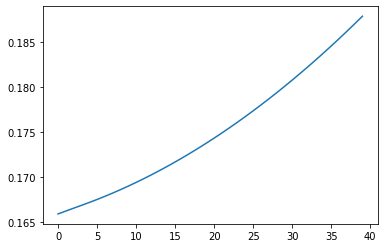

In [17]:
plt.plot(cms2_params.alpha);

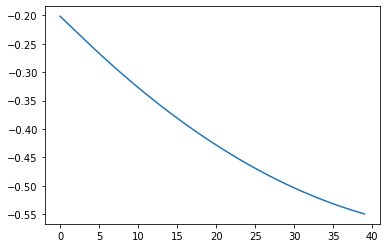

In [18]:
plt.plot(cms2_params.rho);

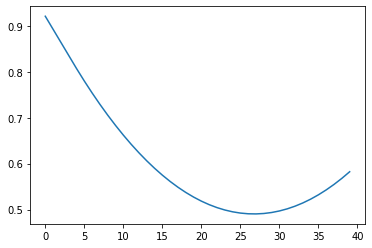

In [19]:
plt.plot(cms2_params.nu);

#### SABR Imp Vol 

In [20]:
#ATM Imp Vol
def get_sabr_vol2(df, beta):
    impvol = []
    for i in range(len(df)):
        F = df.loc[i, 'swap_rates']
        alpha = df.loc[i, 'alpha']
        rho = df.loc[i, 'rho']
        nu = df.loc[i, 'nu']
        T = df.loc[i, 'start']
        impvol.append(SABR(F, F, T, alpha, beta, rho, nu))
    return impvol

cms2_params['sabr_vol'] = get_sabr_vol2(cms2_params, beta)

#### PV 

In [21]:
def CMSRate2(df, m, N):
    cms_rate = []
    for i in range(len(df)):
        F = df.loc[i, 'swap_rates']
        sigma = df.loc[i, 'sabr_vol']
        DF = df.loc[i, 'Discount']
        T = df.loc[i, 'start']
        integral1 = integrate.quad(lambda k: integral_rec(F, k, m, N, sigma, T, DF), 0, F)
        integral2 = integrate.quad(lambda k: integral_pay(F, k, m, N, sigma, T, DF), F, np.inf)
        cms_rate.append(g_0(F)+np.sum(integral1+integral2))
    return cms_rate

m2 = 4
N2 = 2.0
cms2_params['CMS_rate'] = CMSRate2(cms2_params, m2, N2)

def CMS_PV2(df):
    pv = 0
    for i in range(len(df)):
        pv += 0.25 * df.loc[i, 'Discount'] * df.loc[i, 'CMS_rate']
    return pv

CMS2x10_PV = CMS_PV2(cms2_params)
CMS2x10_PV

0.3830071947225676

## Q2
### Comparison of Forward Swap Rates and CMS Rates 

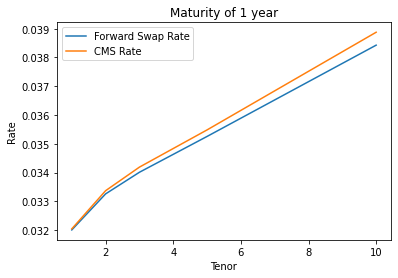

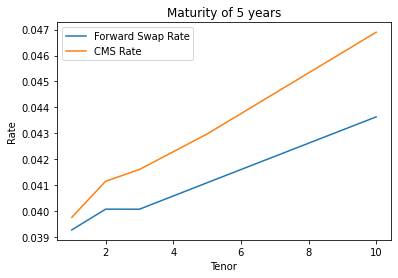

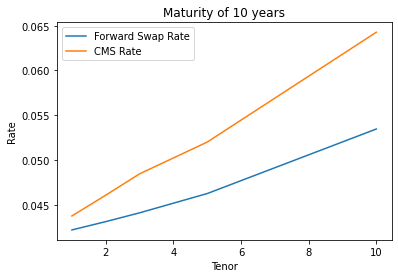

In [22]:
fwd_swap = pd.read_csv('fwd_swap_rate.csv').drop(columns = 'Unnamed: 0')

cms_rate = fwd_swap[['start', 'tenor', 'end', 'swap_rates']]
cms_rate['sabr_vol'] = SABR_vol.loc[:, 'ATM']

# Semi-annual payment
def CMSRate3(df, m):
    cms_rate = []
    for i in range(len(df)):
        F = df.loc[i, 'swap_rates']
        N = df.loc[i, 'tenor']
        sigma = df.loc[i, 'sabr_vol']
        T = df.loc[i, 'start']
        Discount = DF.loc[T, 'OIS_discount_list']
        integral1 = integrate.quad(lambda k: integral_rec(F, k, m, N, sigma, T, Discount), 0, F)
        integral2 = integrate.quad(lambda k: integral_pay(F, k, m, N, sigma, T, Discount), F, np.inf)
        cms_rate.append(g_0(F)+np.sum(integral1+integral2))
    return cms_rate

m = 2
cms_rate['CMS_Rate'] = CMSRate3(cms_rate, m)

def comparison(df):
    for i in [1, 5, 10]:
        swap = df[df['start'] == i]['swap_rates']
        cms = df[df['start'] == i]['CMS_Rate']
        tenor = df[df['start'] == i]['tenor']
        plt.plot(tenor, swap, label = 'Forward Swap Rate')
        plt.plot(tenor, cms, label = 'CMS Rate')
        plt.xlabel('Tenor')
        plt.ylabel('Rate')
        if i == 1:
            plt.title('Maturity of %d year'%i)
        else:
            plt.title('Maturity of %d years'%i)
        plt.legend()
        plt.show()

comparison(cms_rate)

In [23]:
# plt.figure(figsize = (12, 8))
# plt.subplot(2, 3, 1)
# plt.plot(cms1_p.alpha)
# plt.title('alpha (10y Tenor)')
# plt.subplot(2, 3, 2)
# plt.title('rho (10y Tenor)')
# plt.plot(cms2_params.rho)
# plt.subplot(2, 3, 3)
# plt.title('nu (10y Tenor)')
# plt.plot(cms2_params.nu) 
# plt.subplot(2, 3, 4)
# plt.title('alpha (2y Tenor)')
# plt.plot(cms2_params.alpha)
# plt.subplot(2, 3, 5)
# plt.title('rho (2y Tenor)')
# plt.plot(cms2_params.rho)
# plt.subplot(2, 3, 6)
# plt.title('nu (2y Tenor)')
# plt.plot(cms2_params.nu)

# df = cms_rate
# plt.figure(figsize = (15, 3.5))
# plt.subplot(1, 3, 1)
# swap = df[df['start'] == 1]['swap_rates']
# cms = df[df['start'] == 1]['CMS_Rate']
# tenor = df[df['start'] == 1]['tenor']
# plt.plot(tenor, swap, label = 'Forward Swap Rate')
# plt.plot(tenor, cms, label = 'CMS Rate')
# plt.xlabel('Tenor')
# plt.ylabel('Rate')
# plt.title('Maturity of 1 year')
# plt.legend()

# plt.subplot(1, 3, 2)
# swap = df[df['start'] == 5]['swap_rates']
# cms = df[df['start'] == 5]['CMS_Rate']
# tenor = df[df['start'] == 5]['tenor']
# plt.plot(tenor, swap, label = 'Forward Swap Rate')
# plt.plot(tenor, cms, label = 'CMS Rate')
# plt.xlabel('Tenor')
# plt.ylabel('Rate')
# plt.title('Maturity of 5 years')

# plt.subplot(1, 3, 3)
# swap = df[df['start'] == 10]['swap_rates']
# cms = df[df['start'] == 10]['CMS_Rate']
# tenor = df[df['start'] == 10]['tenor']
# plt.plot(tenor, swap, label = 'Forward Swap Rate')
# plt.plot(tenor, cms, label = 'CMS Rate')
# plt.xlabel('Tenor')
# plt.ylabel('Rate')
# plt.title('Maturity of 10 years')


# m1 = df[df['start'] == 1]['CMS_Rate'] - df[df['start'] == 1]['swap_rates']
# m5 = df[df['start'] == 5]['CMS_Rate'] - df[df['start'] == 5]['swap_rates']
# m10 = df[df['start'] == 10]['CMS_Rate'] - df[df['start'] == 10]['swap_rates']
# plt.figure(figsize = (10, 5))
# plt.plot(df[df['start'] == 1]['tenor'],m1,label = 'CMS-Swap (1y Maturity)')
# plt.plot(df[df['start'] == 1]['tenor'],m5,label = 'CMS-Swap (5y Maturity)')
# plt.plot(df[df['start'] == 1]['tenor'],m10,label = 'CMS-Swap (10y Maturity)')
# plt.legend()
# plt.xlabel('Tenor')
# plt.ylabel('Rate')
# plt.title('The Difference between CMS Rates and Forward Swap Rates with Different Maturity')